# Main Dashboard of PhD experiments in pre silicon AI/DB workloads

In [1]:
%matplotlib inline
results_file = 'presilicon_results.csv'
import os
#from pca.analytics import *
from pca.pca import *
from pre_silicon.presi_data_gen import *
from clustering.distortion import *
from clustering.clustering import *
from clustering.cluster_score import *

/usr/local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Characterization of worklaods based on instructions kind

,arithmetic,branch,store,load,vector,io,other
redis_memtier_4cpu,0.115361,0.300828,0.386302,0.029231,0.002293,0.000114,0.165872
resnet50_int8,0.178218,0.187661,0.249629,0.023363,0.073597,0.000118,0.287415
resnet50_fp32,0.177719,0.180546,0.244436,0.022004,0.089545,0.000118,0.285633
redis_memtier_12cpu,0.103911,0.311147,0.411453,0.023082,0.001640,0.000128,0.148639
redis_memtier_16cpu,0.101429,0.313106,0.417137,0.021712,0.001520,0.000129,0.144967
redis_memtier_2cpu_gated,0.140167,0.283461,0.336874,0.035094,0.003072,0.000100,0.201232
redis_memtier_8cpu,0.107708,0.307462,0.402751,0.025026,0.001853,0.000123,0.155077
benchdnn_bf16,0.143012,0.228715,0.306713,0.029471,0.029788,0.000117,0.262184
resnet101_throughput_avx_fp32,0.113997,0.147215,0.184079,0.018616,0.237394,0.000078,0.298621
resnet101_throughput_amx_fp32,0.113839,0.149985,0.186267,0.018901,0.234428,0.000077,0.296504


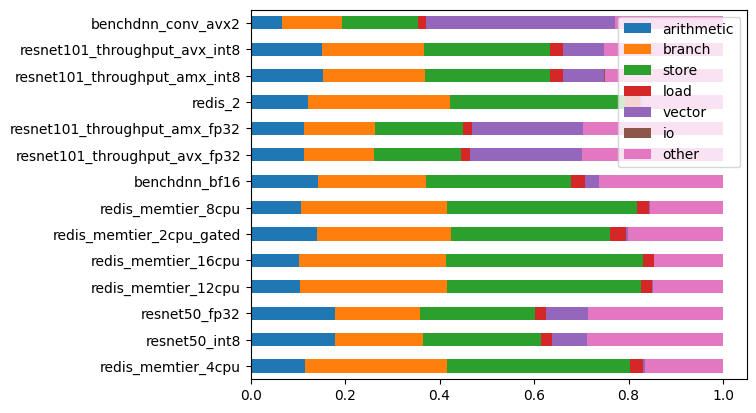

In [2]:
files = dir_list = os.listdir("tests/pre_silicon_runs_ml_db")
my_labels = ['arithmetic', 'branch', 'store', 'load', 'vector' , 'io', 'other']
df_global = pd.DataFrame(columns=my_labels)
for file_name in files:
    test_name = file_name.strip("csv").strip(".")
    df = read_histogram(os.path.join("tests/pre_silicon_runs_ml_db",file_name))
    df_sumary,_ = calculate_values(df)
    df_global.loc[test_name] = df_sumary['probability'].values.tolist()

display(df_global)
plot_stacked_bar(df_global)

df_global.reset_index(inplace=True)
df_global = df_global.rename(columns={"index": "test_name"} )

df_global.to_csv("presilicon_results_spec.csv")

## PCA

In [3]:


df = df_global

df_ = df.loc[:, df.columns != 'test_name']
df_ = (df_-df_.min())/(df_.max()-df_.min())
extracted_col = df["test_name"]
df_.insert(0, 'test_name', extracted_col)
df_.set_index('test_name')
df_.to_csv('normalized_speccpu_df.csv')
df = df_

features = list(df.columns)[1:]
test_column = list(df.columns)[0]

pca_df = get_PCA(df,features)

## Explained Variance

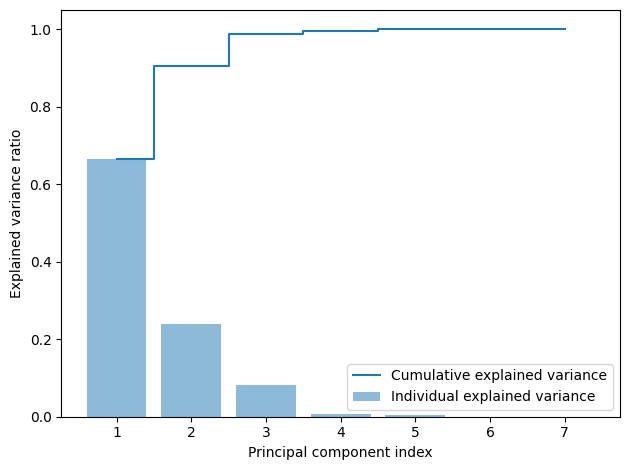

In [4]:
from pca.pca import *
x = get_features(df_global,features)
X_std = StandardScaler().fit_transform(x)
exp_var_pca = get_explained_variance(X_std)
plot_explained_variance(exp_var_pca)

## Display PCA

In [5]:
filename = 'post_silicon/summary_phd.csv'
df2 = pd.read_csv(filename)
df2.fillna(0,inplace=True)

merged_df = pca_df.merge(df2[['test_name', 'Kind']], on='test_name', how='left')

merged_df.loc[merged_df['test_name'].str.contains('redis', case=False, na=False), 'Kind'] = 1
merged_df.loc[merged_df['test_name'].str.contains('resnet', case=False, na=False), 'Kind'] = 0
merged_df.loc[merged_df['test_name'].str.contains('benchdnn', case=False, na=False), 'Kind'] = 0


display(merged_df)



,principal component 1,principal component 2,test_name,Kind
0,-2.026623,0.597176,redis_memtier_4cpu,1.0
1,0.720825,-2.018397,resnet50_int8,0.0
2,0.924069,-1.910955,resnet50_fp32,0.0
3,-2.232027,1.296451,redis_memtier_12cpu,1.0
4,-2.227643,1.471389,redis_memtier_16cpu,1.0
5,-1.520603,-0.622840,redis_memtier_2cpu_gated,1.0
6,-2.150937,1.062229,redis_memtier_8cpu,1.0
7,-0.488707,-1.152886,benchdnn_bf16,0.0
8,3.192015,0.281263,resnet101_throughput_avx_fp32,0.0
9,3.141067,0.300766,resnet101_throughput_amx_fp32,0.0


                        test_name  ID
0              redis_memtier_4cpu   0
1                   resnet50_int8   1
2                   resnet50_fp32   2
3             redis_memtier_12cpu   3
4             redis_memtier_16cpu   4
5        redis_memtier_2cpu_gated   5
6              redis_memtier_8cpu   6
7                   benchdnn_bf16   7
8   resnet101_throughput_avx_fp32   8
9   resnet101_throughput_amx_fp32   9
10                        redis_2  10
11  resnet101_throughput_amx_int8  11
12  resnet101_throughput_avx_int8  12
13             benchdnn_conv_avx2  13


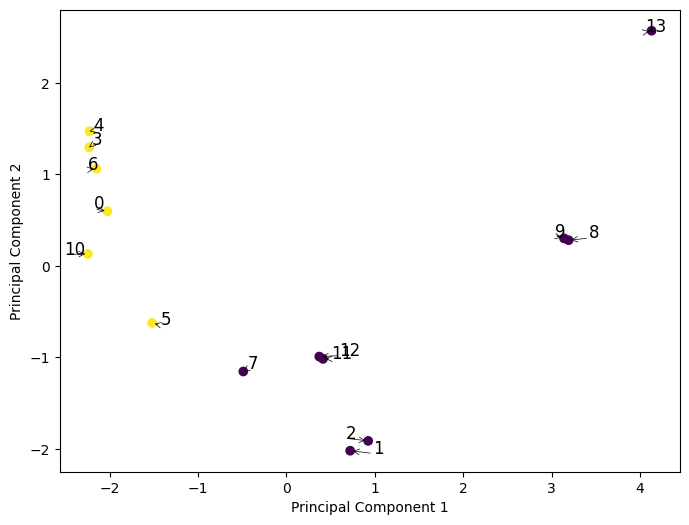

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create a single plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Scatter plot
scatter = ax1.scatter(x=merged_df['principal component 1'], y=merged_df['principal component 2'], c=merged_df['Kind'], cmap='viridis')
for i, label in enumerate(merged_df['test_name']):
    x = merged_df['principal component 1'][i]
    y = merged_df['principal component 2'][i]
    # Introduce random jitter to label positions
    jitter_x = np.random.uniform(-0.3, 0.3)
    jitter_y = np.random.uniform(-0.03, 0.03)
    ax1.text(x + jitter_x, y + jitter_y, i, fontsize=12) # Adjust fontsize here and add an offset to x and y positions
    ax1.annotate("", xy=(x, y), xytext=(x + jitter_x, y + jitter_y), arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
#ax1.set_title("Scatter Plot of Principal Components")

# Table
#table_data = merged_df[['test_name']].copy()
#table_data['ID'] = merged_df.index
#table = ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
#table.auto_set_font_size(False)
#table.set_fontsize(10)
#table.scale(1.2, 1.2)
#ax2.axis('off')
#ax2.set_title("Table of Test Names and IDs")

# Print table
table_data = merged_df[['test_name']].copy()
table_data['ID'] = merged_df.index
print(table_data)


# Show plot
plt.show()
pca_df=merged_df

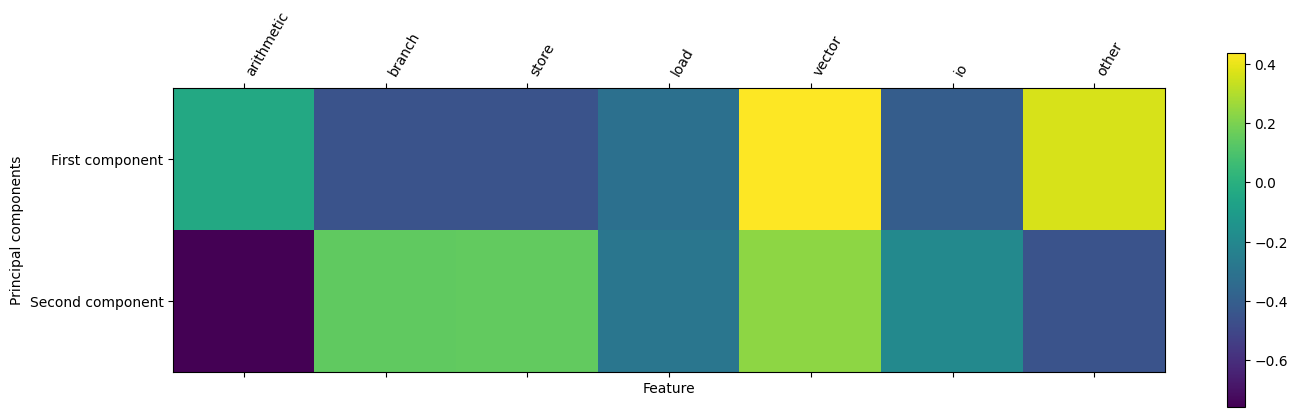

In [7]:
from pca.pca import *
plot_pca_vectors(X_std, features)

,PRED,test_name
0,0,redis_memtier_4cpu
0,0,resnet50_int8
0,0,resnet50_fp32
0,0,redis_memtier_12cpu
0,0,redis_memtier_16cpu
0,0,redis_memtier_2cpu_gated
0,0,redis_memtier_8cpu
0,0,benchdnn_bf16
0,0,redis_2
0,0,resnet101_throughput_amx_int8


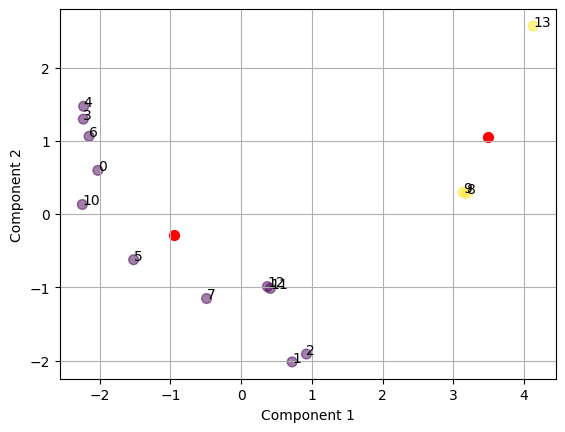

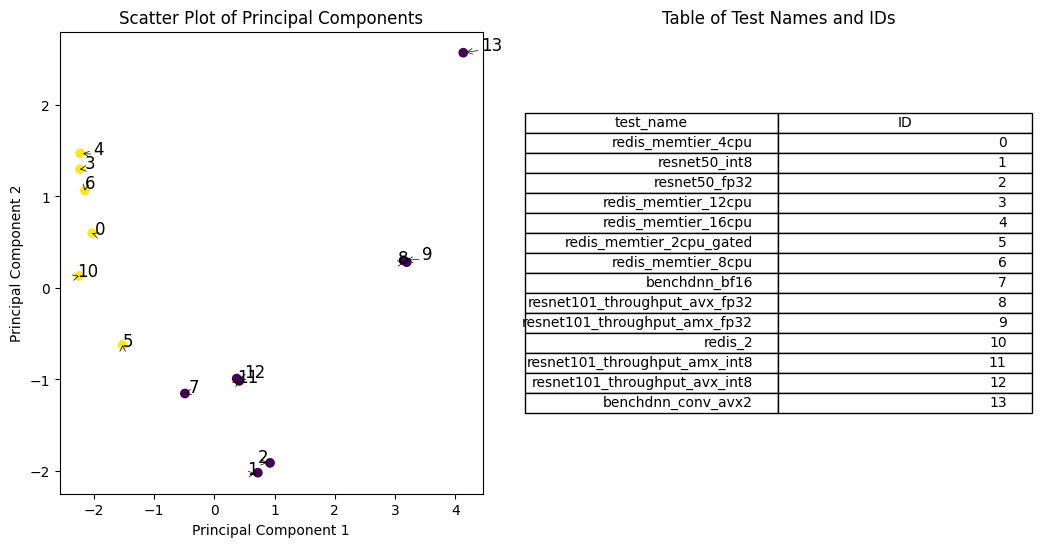

In [8]:
from clustering.clustering import *
df_result,kmeans,SSE = kmean_cluster(pca_df,2)
display(df_result)
plot_kmeans(pca_df, kmeans)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

merged_df = pca_df
# Scatter plot
scatter = ax1.scatter(x=merged_df['principal component 1'], y=merged_df['principal component 2'], c=merged_df['Kind'], cmap='viridis')
for i, label in enumerate(merged_df['test_name']):
    x = merged_df['principal component 1'][i]
    y = merged_df['principal component 2'][i]
    # Introduce random jitter to label positions
    jitter_x = np.random.uniform(-0.3, 0.3)
    jitter_y = np.random.uniform(-0.03, 0.03)
    ax1.text(x + jitter_x, y + jitter_y, i, fontsize=12) # Adjust fontsize here and add an offset to x and y positions
    ax1.annotate("", xy=(x, y), xytext=(x + jitter_x, y + jitter_y), arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_title("Scatter Plot of Principal Components")

# Table
table_data = merged_df[['test_name']].copy()
table_data['ID'] = merged_df.index
table = ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax2.axis('off')
ax2.set_title("Table of Test Names and IDs")

# Show plot
plt.show()

# Get the test cases closer to centroid

In [9]:
from sklearn.metrics import pairwise_distances_argmin_min
X = pd.read_csv("pca.csv", usecols = ['principal component 1','principal component 2'])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
pca_df_ = pd.read_csv("pca.csv")
df = pca_df_.iloc[closest]
df

,Unnamed: 0,principal component 1,principal component 2,test_name
5,5,-1.520603,-0.622840,redis_memtier_2cpu_gated
8,8,3.192015,0.281263,resnet101_throughput_avx_fp32


,test_name,arithmetic,branch,store,load,vector,io,other
5,redis_memtier_2cpu_gated,0.140167,0.283461,0.336874,0.035094,0.003072,0.000100,0.201232
8,resnet101_throughput_avx_fp32,0.113997,0.147215,0.184079,0.018616,0.237394,0.000078,0.298621


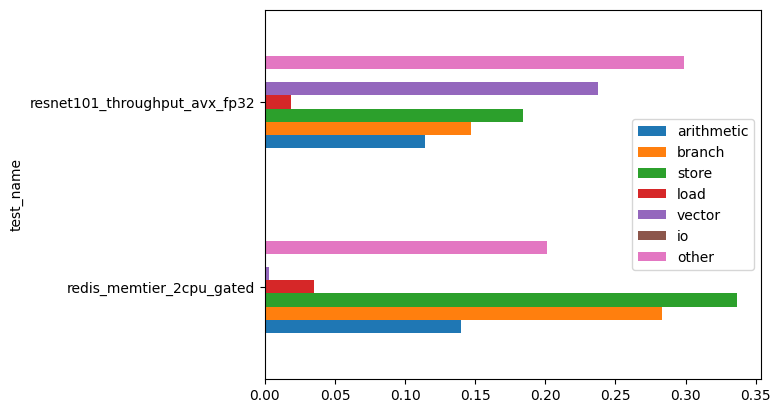

In [10]:
list_tests = df['test_name'].tolist()
df2 = df_global[df_global['test_name'].isin(list_tests)]
df2.plot.barh(x="test_name")
df2

### Automatic label of clusters based cosine similarity to FP/INT


\begin{equation}
\cos ({\bf t},{\bf e})= {{\bf t} {\bf e} \over \|{\bf t}\| \|{\bf e}\|} = \frac{ \sum_{i=1}^{n}{{\bf t}_i{\bf e}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf t}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf e}_i)^2}} }
\end{equation}

,principal component 1,principal component 2,test_name,Kind
0,-2.026623,0.597176,redis_memtier_4cpu,1.0
1,0.720825,-2.018397,resnet50_int8,0.0
2,0.924069,-1.910955,resnet50_fp32,0.0
3,-2.232027,1.296451,redis_memtier_12cpu,1.0
4,-2.227643,1.471389,redis_memtier_16cpu,1.0
5,-1.520603,-0.622840,redis_memtier_2cpu_gated,1.0
6,-2.150937,1.062229,redis_memtier_8cpu,1.0
7,-0.488707,-1.152886,benchdnn_bf16,0.0
8,3.192015,0.281263,resnet101_throughput_avx_fp32,0.0
9,3.141067,0.300766,resnet101_throughput_amx_fp32,0.0



A = PRED -> 0
cosine_similarity vs fp_tests 0.5330017908890261
cosine_similarity vs int_tests 0.7385489458759965
cosine_similarity_int > cosine_similarity_fp
Assigining 1 label to pred cluster

B = PRED -> 1
cosine_similarity vs fp_tests 0.6123724356957945
cosine_similarity vs int_tests 0.0
cosine_similarity_fp > cosine_similarity_int
Assigining 0 label to pred cluster


,labels,val_pred,val_true
0,resnet50_int8,1,0.0
0,resnet50_fp32,1,0.0
0,resnet101_throughput_avx_int8,1,0.0
1,resnet101_throughput_avx_fp32,0,0.0
0,resnet101_throughput_amx_int8,1,0.0
1,resnet101_throughput_amx_fp32,0,0.0
0,redis_memtier_8cpu,1,1.0
0,redis_memtier_4cpu,1,1.0
0,redis_memtier_2cpu_gated,1,1.0
0,redis_memtier_16cpu,1,1.0


,labels,val_pred,val_true
0,resnet50_int8,1,0.0
0,resnet50_fp32,1,0.0
0,resnet101_throughput_avx_int8,1,0.0
0,resnet101_throughput_amx_int8,1,0.0
0,benchdnn_bf16,1,0.0



adjusted_rand_score 0.02569593147751606

normalized_mutual_info_score 0.23541808259515326

fowlkes_mallows_score 0.5606732120242913

hamming_distance 0.35714285714285715


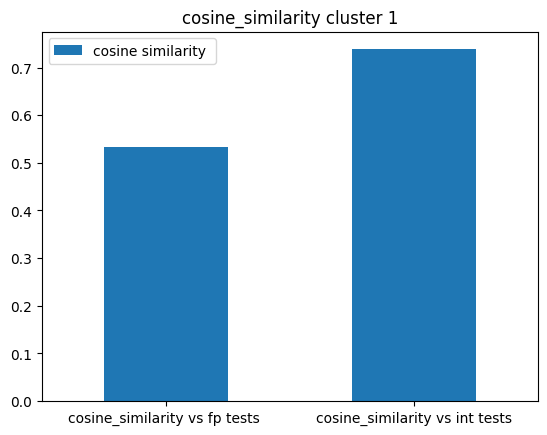

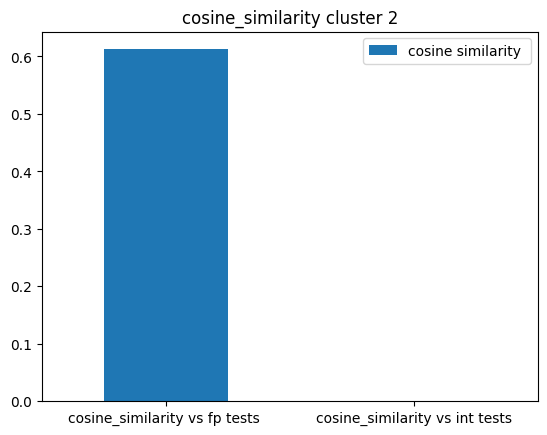

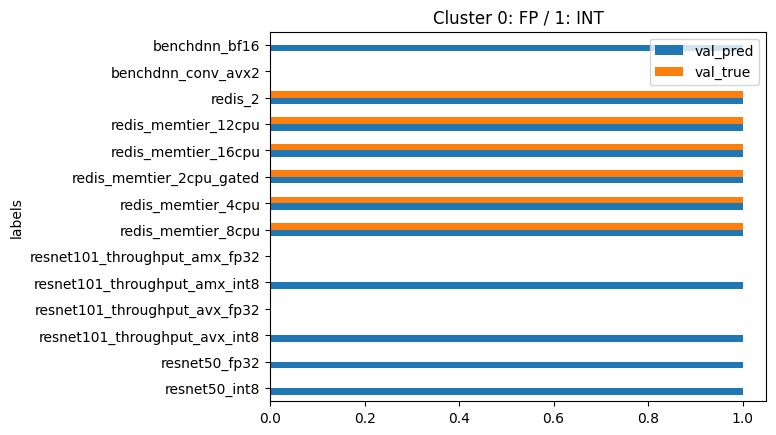

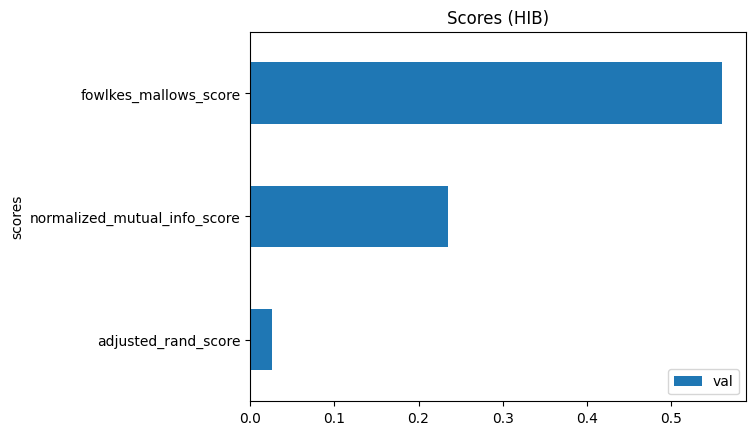

In [11]:
display(pca_df)
df_sorted = pca_df.sort_values(by='Kind')
fp_tests = df_sorted[df_sorted['Kind'] == 0]
int_tests = df_sorted[df_sorted['Kind'] == 1]

df = df_result
#display(df)
df_sorted = df.sort_values(by='PRED')
A = df_sorted[df_sorted['PRED'] == 0]
B = df_sorted[df_sorted['PRED'] == 1]


C = normalize(A,B,fp_tests,int_tests)
C_sorted =  C.sort_values(by='test_name', ascending=False)

REAL = pca_df
REAL_sorted = REAL.sort_values(by='test_name', ascending=False)

labels_pred = C_sorted["PRED"].tolist()
labels_pred_ = [eval(i) for i in labels_pred]
labels_pred = labels_pred_

labels_true = REAL_sorted["Kind"].tolist()

df = pd.DataFrame({'labels':C_sorted['test_name'], 'val_pred':labels_pred, 'val_true':labels_true})
display(df)
df.to_csv("clusters.csv")

df_ = df.loc[~(df['val_pred'] == df['val_true'])]
display(df_)

ax = df.plot.barh(x='labels', y=['val_pred','val_true'],  rot=0, title= "Cluster 0: FP / 1: INT")

scores_result = scores(labels_true,labels_pred)

df = pd.DataFrame({'scores':['adjusted_rand_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score'], 'val':scores_result[:-1]})
ax = df.plot.barh(x='scores', y='val', rot=0, title= "Scores (HIB)")

,Unnamed: 0,labels,val_pred,val_true
0,0,resnet50_int8,1,0.0
1,0,resnet50_fp32,1,0.0
2,0,resnet101_throughput_avx_int8,1,0.0
3,1,resnet101_throughput_avx_fp32,0,0.0
4,0,resnet101_throughput_amx_int8,1,0.0
5,1,resnet101_throughput_amx_fp32,0,0.0
6,0,redis_memtier_8cpu,1,1.0
7,0,redis_memtier_4cpu,1,1.0
8,0,redis_memtier_2cpu_gated,1,1.0
9,0,redis_memtier_16cpu,1,1.0


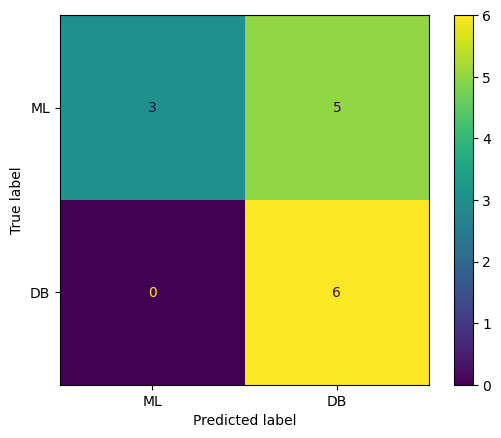

In [12]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

df = pd.read_csv('clusters.csv')
display(df)
actual = df['val_true'].tolist()
predicted = df['val_pred'].tolist()

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['ML', 'DB'])

cm_display.plot()
plt.show()

## Get best number of clusters based on variance 

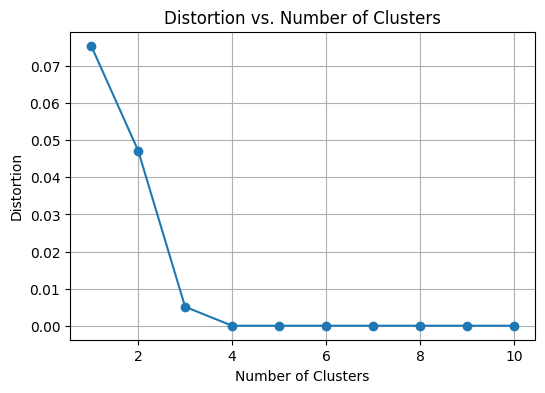

'Optimal number of clusters = 1'

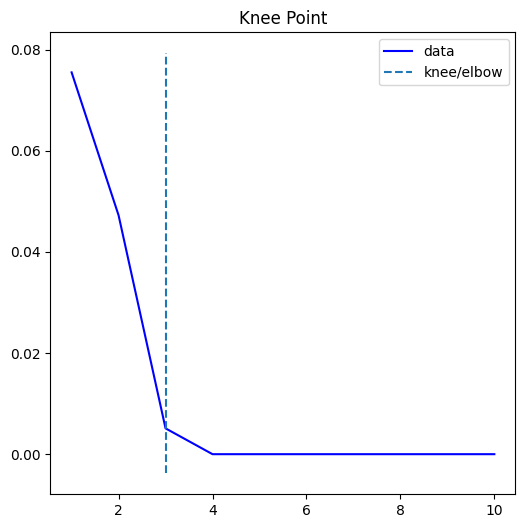

In [13]:
from clustering.distortion import *
from clustering.cluster_score import *
#clusters = calculate_elbow(pca_df)[0]
x1 = pca_df["principal component 1"].values
x2 = pca_df["principal component 2"].values
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
clusters,distortions,inertias = find_optimal_clusters(X, max_clusters=10)
display(f"Optimal number of clusters = {clusters}")

x = range(1, len(distortions)+1)
kn = KneeLocator(x, distortions, curve='convex', direction='decreasing')
kn.plot_knee()

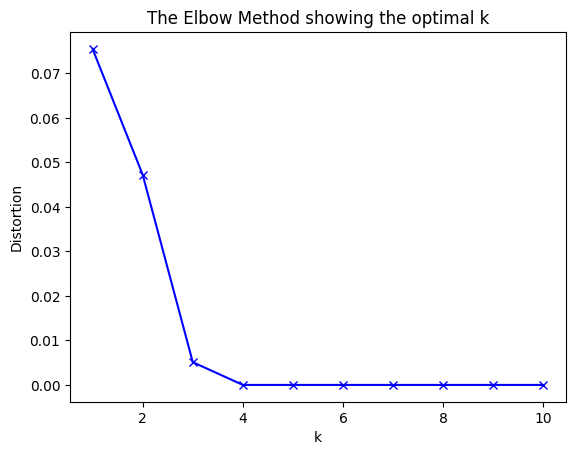

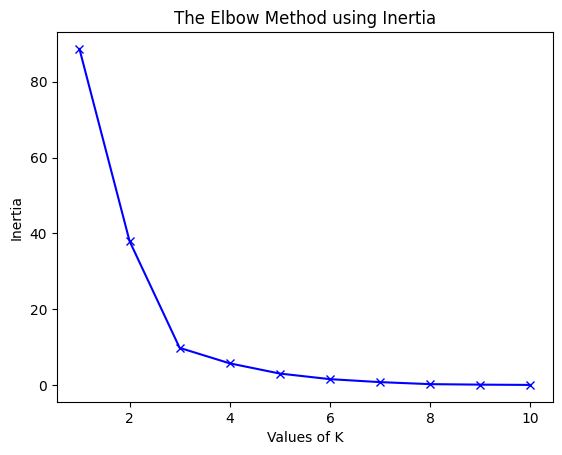

In [14]:
plot_elbow(range(1,11),distortions,inertias)


## Clasification based on N number of clusters

,PRED,test_name
0,0,redis_memtier_4cpu
0,0,redis_memtier_12cpu
0,0,redis_memtier_16cpu
0,0,redis_memtier_2cpu_gated
0,0,redis_memtier_8cpu
0,0,redis_2
1,1,resnet101_throughput_avx_fp32
1,1,resnet101_throughput_amx_fp32
1,1,benchdnn_conv_avx2
2,2,resnet50_int8


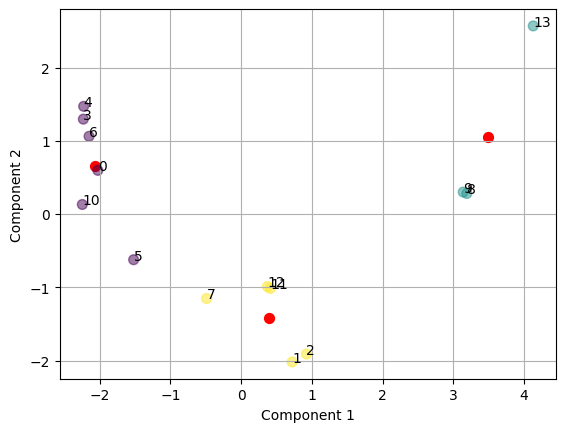

In [15]:
from clustering.clustering import *
df_result,kmeans,SSE = kmean_cluster(pca_df,3)
display(df_result)
plot_kmeans(pca_df, kmeans)

,test_name,arithmetic,branch,store,load,vector,io,other
0,redis_memtier_4cpu,0.115361,0.300828,0.386302,0.029231,0.002293,0.000114,0.165872
8,resnet101_throughput_avx_fp32,0.113997,0.147215,0.184079,0.018616,0.237394,0.000078,0.298621
11,resnet101_throughput_amx_int8,0.152773,0.216569,0.263915,0.027390,0.088450,0.000100,0.250804


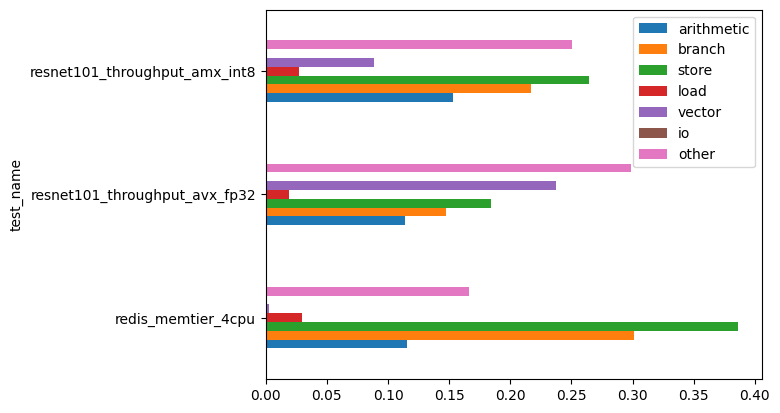

In [16]:
from sklearn.metrics import pairwise_distances_argmin_min
X = pd.read_csv("pca.csv", usecols = ['principal component 1','principal component 2'])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
pca_df_ = pd.read_csv("pca.csv")
df = pca_df_.iloc[closest]
df
list_tests = df['test_name'].tolist()
df2 = df_global[df_global['test_name'].isin(list_tests)]
df2.plot.barh(x="test_name")
df2

[88.65221528666055, 37.98240644886526, 9.816626994577984, 5.735358878775842, 3.039004332513956, 1.5669918667754121, 0.7821824167939555, 0.2502390267338169, 0.11755790948077777]


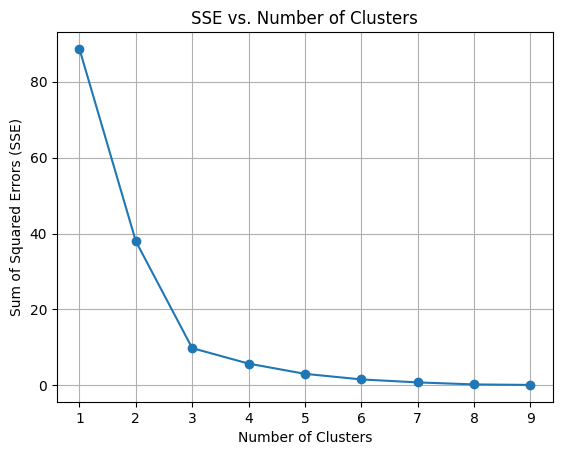

In [17]:
SSE_vector = []
for x in range(1,10):
    df_result_,kmeans,SSE = kmean_cluster(pca_df,x)
    SSE_vector.append(SSE)
print(SSE_vector)

# Plot SSE vs. number of clusters
plt.plot(range(1,10), SSE_vector, marker='o')
plt.title('SSE vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()


,principal component 1,principal component 2,test_name,Kind
0,-2.026623,0.597176,redis_memtier_4cpu,1.0
1,0.720825,-2.018397,resnet50_int8,0.0
2,0.924069,-1.910955,resnet50_fp32,0.0
3,-2.232027,1.296451,redis_memtier_12cpu,1.0
4,-2.227643,1.471389,redis_memtier_16cpu,1.0
5,-1.520603,-0.622840,redis_memtier_2cpu_gated,1.0
6,-2.150937,1.062229,redis_memtier_8cpu,1.0
7,-0.488707,-1.152886,benchdnn_bf16,0.0
8,3.192015,0.281263,resnet101_throughput_avx_fp32,0.0
9,3.141067,0.300766,resnet101_throughput_amx_fp32,0.0


,PRED,test_name
0,0,redis_memtier_4cpu
0,0,redis_memtier_12cpu
0,0,redis_memtier_16cpu
0,0,redis_memtier_2cpu_gated
0,0,redis_memtier_8cpu
0,0,redis_2
1,1,resnet101_throughput_avx_fp32
1,1,resnet101_throughput_amx_fp32
1,1,benchdnn_conv_avx2
2,2,resnet50_int8


/var/folders/cq/r380vqnd7fd_v5hhy522gw140000gn/T/ipykernel_69443/921413153.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B_['PRED'] = 1



A = PRED -> 0
cosine_similarity vs fp_tests 0.0
cosine_similarity vs int_tests 1.0000000000000002
cosine_similarity_int > cosine_similarity_fp
Assigining 1 label to pred cluster

B = PRED -> 1
cosine_similarity vs fp_tests 0.6123724356957945
cosine_similarity vs int_tests 0.0
cosine_similarity_fp > cosine_similarity_int
Assigining 0 label to pred cluster

A = PRED -> 0
cosine_similarity vs fp_tests 0.0
cosine_similarity vs int_tests 1.0000000000000002
cosine_similarity_int > cosine_similarity_fp
Assigining 1 label to pred cluster

B = PRED -> 1
cosine_similarity vs fp_tests 0.7905694150420948
cosine_similarity vs int_tests 0.0
cosine_similarity_fp > cosine_similarity_int
Assigining 0 label to pred cluster


,PRED,test_name
9,0,resnet50_int8
10,0,resnet50_fp32
11,0,resnet101_throughput_avx_int8
0,0,resnet101_throughput_avx_fp32
12,0,resnet101_throughput_amx_int8
1,0,resnet101_throughput_amx_fp32
2,1,redis_memtier_8cpu
3,1,redis_memtier_4cpu
4,1,redis_memtier_2cpu_gated
5,1,redis_memtier_16cpu


,labels,val_pred,val_true
9,resnet50_int8,0,0.0
10,resnet50_fp32,0,0.0
11,resnet101_throughput_avx_int8,0,0.0
0,resnet101_throughput_avx_fp32,0,0.0
12,resnet101_throughput_amx_int8,0,0.0
1,resnet101_throughput_amx_fp32,0,0.0
2,redis_memtier_8cpu,1,1.0
3,redis_memtier_4cpu,1,1.0
4,redis_memtier_2cpu_gated,1,1.0
5,redis_memtier_16cpu,1,1.0


,labels,val_pred,val_true



adjusted_rand_score 1.0

normalized_mutual_info_score 1.0

fowlkes_mallows_score 1.0

hamming_distance 0.0


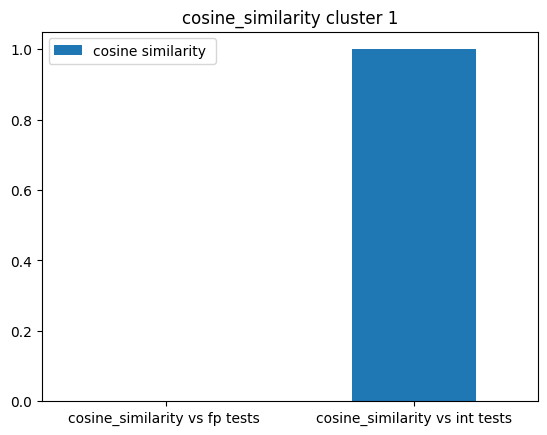

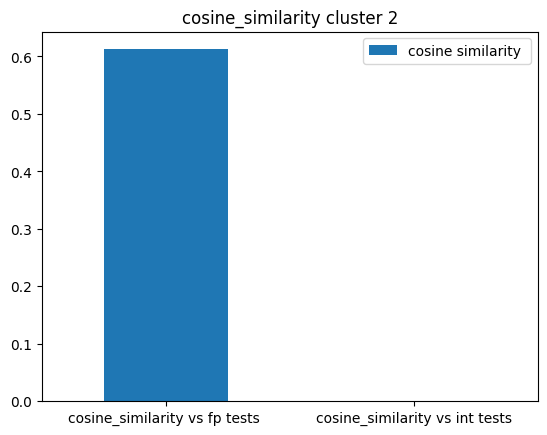

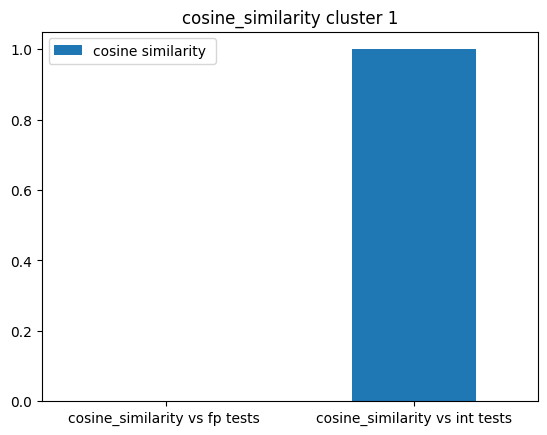

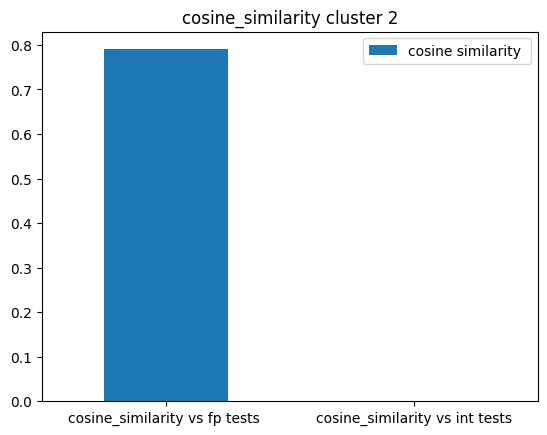

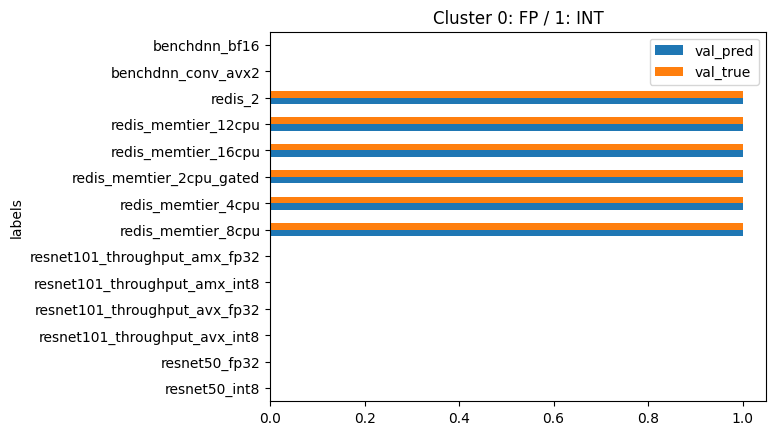

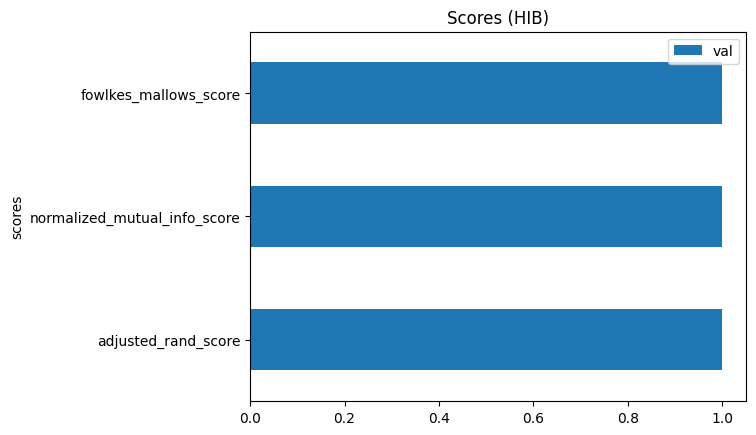

In [18]:
pca_df_ = pd.read_csv("pca.csv")
display(pca_df)
df_sorted = pca_df.sort_values(by='Kind')
fp_tests = df_sorted[df_sorted['Kind'] == 0]
int_tests = df_sorted[df_sorted['Kind'] == 1]

df = df_result
display(df)
df_sorted = df.sort_values(by='PRED')
A = df_sorted[df_sorted['PRED'] == 0]
B = df_sorted[df_sorted['PRED'] == 1]

# option 1
# convert 2 -> 1
B_ = df_sorted[df_sorted['PRED'] == 2]
B_['PRED'] = 1

C = normalize(A,B,fp_tests,int_tests)
C_sorted =  C.sort_values(by='test_name', ascending=False)

D = normalize(A,B_,fp_tests,int_tests)
D_sorted =  D.sort_values(by='test_name', ascending=False)

complete = pd.concat([C_sorted, D_sorted], ignore_index=True).drop_duplicates()
complete = complete.sort_values(by='test_name', ascending=False)
display(complete)

REAL = pca_df
REAL_sorted = REAL.sort_values(by='test_name', ascending=False)

labels_pred = complete["PRED"].tolist()
labels_pred_ = [eval(i) for i in labels_pred]
labels_pred = labels_pred_

labels_true = REAL_sorted["Kind"].tolist()



df = pd.DataFrame({'labels':complete['test_name'], 'val_pred':labels_pred, 'val_true':labels_true})
display(df)
df.to_csv("clusters.csv")

df_ = df.loc[~(df['val_pred'] == df['val_true'])]
display(df_)

ax = df.plot.barh(x='labels', y=['val_pred','val_true'],  rot=0, title= "Cluster 0: FP / 1: INT")

scores_result = scores(labels_true,labels_pred)

df = pd.DataFrame({'scores':['adjusted_rand_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score'], 'val':scores_result[:-1]})
ax = df.plot.barh(x='scores', y='val', rot=0, title= "Scores (HIB)")

,Unnamed: 0,labels,val_pred,val_true
0,9,resnet50_int8,0,0.0
1,10,resnet50_fp32,0,0.0
2,11,resnet101_throughput_avx_int8,0,0.0
3,0,resnet101_throughput_avx_fp32,0,0.0
4,12,resnet101_throughput_amx_int8,0,0.0
5,1,resnet101_throughput_amx_fp32,0,0.0
6,2,redis_memtier_8cpu,1,1.0
7,3,redis_memtier_4cpu,1,1.0
8,4,redis_memtier_2cpu_gated,1,1.0
9,5,redis_memtier_16cpu,1,1.0


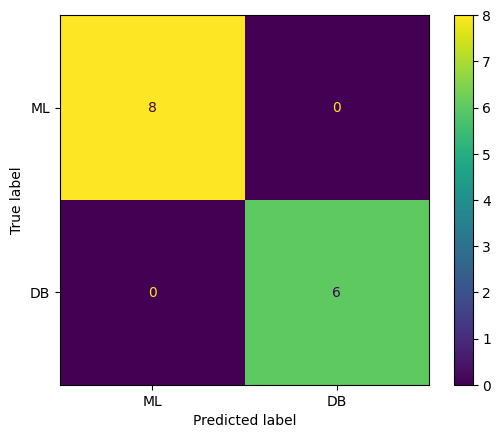

In [19]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

df = pd.read_csv('clusters.csv')
display(df)
actual = df['val_true'].tolist()
predicted = df['val_pred'].tolist()

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['ML', 'DB'])

cm_display.plot()
plt.show()

## Hiearchial clustering

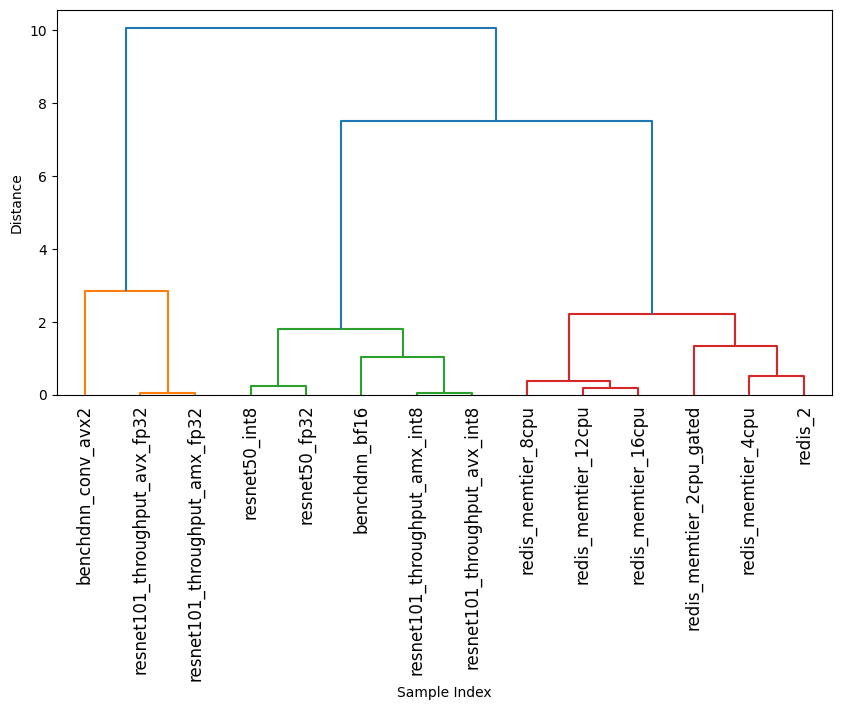

In [20]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate sample data
#X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
X = pca_df[['principal component 1', 'principal component 2']].copy()

# Perform hierarchical clustering to obtain the linkage matrix
Z = hierarchy.linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z,labels=pca_df['test_name'].values)

# Rotate the labels vertically
plt.xticks(rotation=90)

#plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## Get optimal set of of clusters based on simulation time vs SSE

In [21]:
list_workloads = pca_df['test_name'].values
# Generate random simulation time values between 1 and 20
simulation_times = np.random.randint(1, 21, size=len(pca_df))

# Add the new column to the DataFrame
pca_df['simulation_time'] = simulation_times
pca_df.to_csv("pca_df_sim_time.csv")


In [22]:
pca_df = pd.read_csv("pca_df_sim_time_fixed_time.csv")

In [23]:
def find_min_simulation_time(df, workloads):
    # Filter the DataFrame based on the provided set of workloads
    filtered_df = df[df['test_name'].isin(workloads)]
    
    # Find the row with the minimum simulation time
    min_row = filtered_df.loc[filtered_df['simulation_time'].idxmin()]
    
    # Extract the workload name and minimum simulation time
    min_workload = min_row['test_name']
    min_time = min_row['simulation_time']
    
    return min_workload, min_time

total_clusters_time_v = []
for x in range(1,10):
    df_result_,kmeans,SSE = kmean_cluster(pca_df,x)
    workloads_per_cluster = {}
    total_clusters_time = 0
    for cluster, group in df_result_.groupby('PRED'):
        workloads = set(group['test_name'].unique())
        min_workload, min_time = find_min_simulation_time(pca_df, workloads)
        print(f"Workload with minimum simulation time: {min_workload}, Time: {min_time}")
        total_clusters_time += min_time
    print(f"Cluster size = {x} Sim time = {total_clusters_time}")
    total_clusters_time_v.append(total_clusters_time)
    
print(total_clusters_time_v)

Workload with minimum simulation time: redis_memtier_8cpu, Time: 9
Cluster size = 1 Sim time = 9
Workload with minimum simulation time: resnet101_throughput_amx_fp32, Time: 32
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9
Cluster size = 2 Sim time = 41
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9
Workload with minimum simulation time: resnet101_throughput_amx_fp32, Time: 32
Workload with minimum simulation time: resnet101_throughput_amx_int8, Time: 61
Cluster size = 3 Sim time = 102
Workload with minimum simulation time: resnet101_throughput_amx_fp32, Time: 32
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9
Workload with minimum simulation time: resnet101_throughput_amx_int8, Time: 61
Workload with minimum simulation time: benchdnn_conv_avx2, Time: 69
Cluster size = 4 Sim time = 171
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9
Workload with minimum simulation time: resnet101_throughput_amx_int8, Time: 6

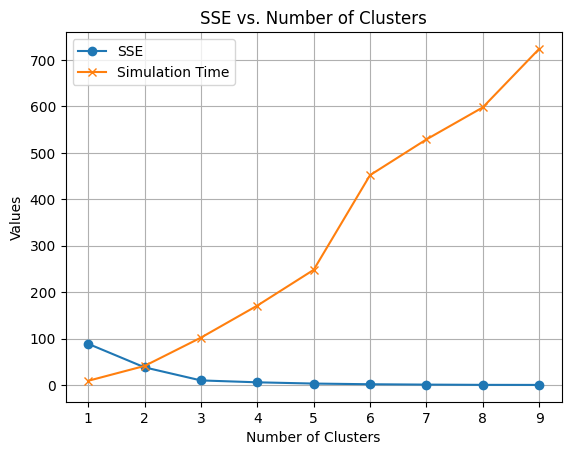

In [24]:
plt.plot(range(1, 10), SSE_vector, marker='o', label='SSE')
plt.plot(range(1, 10), total_clusters_time_v, marker='x', label='Simulation Time')
plt.title('SSE vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

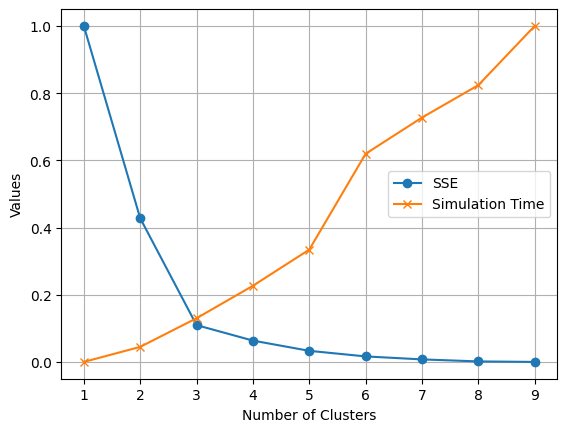

In [25]:
# Min-max normalization for total_clusters_time_v
min_total_clusters_time_v = min(total_clusters_time_v)
max_total_clusters_time_v = max(total_clusters_time_v)
normalized_total_clusters_time_v = [(x - min_total_clusters_time_v) / (max_total_clusters_time_v - min_total_clusters_time_v) for x in total_clusters_time_v]

# Min-max normalization for SSE_vector
min_SSE_vector = min(SSE_vector)
max_SSE_vector = max(SSE_vector)
normalized_SSE_vector = [(x - min_SSE_vector) / (max_SSE_vector - min_SSE_vector) for x in SSE_vector]

plt.plot(range(1, 10), normalized_SSE_vector, marker='o', label='SSE')
plt.plot(range(1, 10), normalized_total_clusters_time_v, marker='x', label='Simulation Time')
#plt.title('SSE vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### Decision Tree Algorithm


In [26]:
display(pca_df)
# Use known kind based on KMEANS prediction
X = pca_df[["principal component 1","principal component 2"]]
y = pca_df[["Kind"]]

accuracy_results = {}

,Unnamed: 0,principal component 1,principal component 2,test_name,Kind,simulation_time
0,0,-2.026623,0.597176,redis_memtier_4cpu,1,77
1,1,0.720825,-2.018397,resnet50_int8,0,169
2,2,0.924069,-1.910955,resnet50_fp32,0,201
3,3,-2.232027,1.296451,redis_memtier_12cpu,1,11
4,4,-2.227643,1.471389,redis_memtier_16cpu,1,13
5,5,-1.520603,-0.622840,redis_memtier_2cpu_gated,1,112
6,6,-2.150937,1.062229,redis_memtier_8cpu,1,9
7,7,-0.488707,-1.152886,benchdnn_bf16,0,69
8,8,3.192015,0.281263,resnet101_throughput_avx_fp32,0,65
9,9,3.141067,0.300766,resnet101_throughput_amx_fp32,0,32


In [27]:
from statistics import mean
from statistics import stdev
def get_accuracty(X,y,loops,clf):
    p_total = []
    r_total = []
    f_total = []

    for i in range(loops):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        clf.fit(X_train,y_train)

        # Predict Accuracy Score
        y_pred = clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted', labels=y_pred,zero_division=1)
        p_total.append(p)
        r_total.append(r)
        f_total.append(f)
    return p_total,r_total,f_total


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

# Split into training and test set
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

loops = 10
clf = DecisionTreeClassifier()
p_total_wpca,r_total_wpca,f_total_wpca = get_accuracty(X,y,loops,clf)
    
print(f"Precision score {mean(p_total_wpca)} STED {stdev(p_total_wpca)}")
print(f"Recall score {mean(r_total_wpca)} STED {stdev(p_total_wpca)}")
print(f"F-beta score {mean(f_total_wpca)} STED {stdev(p_total_wpca)}")

accuracy_results['Decision_Tree_precision_score_wpca'] = mean(p_total_wpca)
accuracy_results['Decision_Tree_recall_score_wpca'] = mean(r_total_wpca)
accuracy_results['Decision_Tree_F_score_wpca'] = mean(f_total_wpca)

Precision score 1.0 STED 0.0
Recall score 1.0 STED 0.0
F-beta score 1.0 STED 0.0


### Decision Tree Algorithm w/o PCA


In [28]:
from statistics import mean
from statistics import stdev

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

loops = 10
clf = DecisionTreeClassifier()

filename = 'normalized_speccpu_df.csv'
df_data = pd.read_csv(filename)
df_data.fillna(0,inplace=True)

if os.path.exists(filename):
    df = pd.read_csv(filename)
    filename = 'post_silicon/summary_phd.csv'
    df2 = pd.read_csv(filename)
    df2.fillna(0,inplace=True)

    merged_df = df_data.merge(df2[['test_name', 'Kind']], on='test_name', how='left')
    merged_df.loc[merged_df['test_name'].str.contains('redis', case=False, na=False), 'Kind'] = 1
    merged_df.loc[merged_df['test_name'].str.contains('resnet', case=False, na=False), 'Kind'] = 0
    merged_df.loc[merged_df['test_name'].str.contains('benchdnn', case=False, na=False), 'Kind'] = 0

    features = list(df.columns)[2:]
    display(merged_df)
    test_column = list(merged_df.columns)[0]
    x = merged_df.loc[:, features].values
    X_std = StandardScaler().fit_transform(x)
    y = merged_df['Kind']

p_total,r_total,f_total = get_accuracty(x,y,loops,clf)
    
print(f"Precision score {mean(p_total)} STED {stdev(p_total)}")
print(f"Recall score {mean(r_total)} STED {stdev(p_total)}")
print(f"F-beta score {mean(f_total)} STED {stdev(p_total)}")

accuracy_results['Decision_Tree_precision_score'] = mean(p_total)
accuracy_results['Decision_Tree_recall_score'] = mean(r_total)
accuracy_results['Decision_Tree_F_score'] = mean(f_total)

,Unnamed: 0,test_name,arithmetic,branch,store,load,vector,io,other,Kind
0,0,redis_memtier_4cpu,0.440633,0.934121,0.879585,0.676694,0.001934,0.786505,0.136051,1.0
1,1,resnet50_int8,1.000000,0.326916,0.345858,0.353143,0.180303,0.846799,0.927069,0.0
2,2,resnet50_fp32,0.995558,0.288742,0.325579,0.278214,0.220196,0.850127,0.915471,0.0
3,3,redis_memtier_12cpu,0.338740,0.989492,0.977802,0.337691,0.000300,0.989432,0.023896,1.0
4,4,redis_memtier_16cpu,0.316657,1.000000,1.000000,0.262130,0.000000,1.000000,0.000000,1.0
5,5,redis_memtier_2cpu_gated,0.661386,0.840939,0.686561,1.000000,0.003883,0.579001,0.366180,1.0
6,6,redis_memtier_8cpu,0.372535,0.969717,0.943821,0.444863,0.000832,0.923003,0.065795,1.0
7,7,benchdnn_bf16,0.686705,0.547193,0.568781,0.689951,0.070713,0.826299,0.762864,0.0
8,8,resnet101_throughput_avx_fp32,0.428498,0.109902,0.089878,0.091440,0.590044,0.263329,1.000000,0.0
9,9,resnet101_throughput_amx_fp32,0.427090,0.124761,0.098422,0.107148,0.582625,0.247475,0.986224,0.0


Precision score 0.9083333333333333 STED 0.21677347794585192
Recall score 0.975 STED 0.21677347794585192
F-beta score 0.9166666666666666 STED 0.21677347794585192


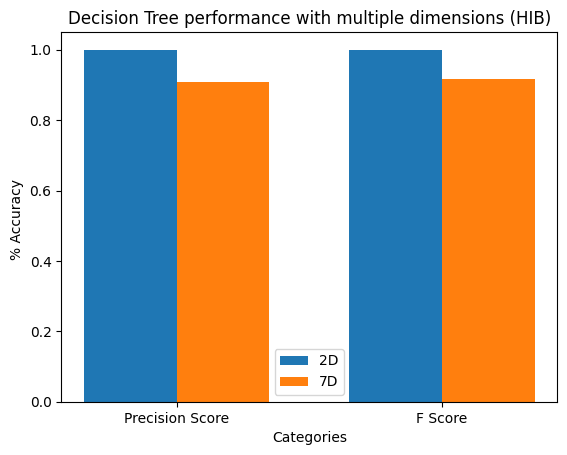

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from statistics import stdev

# Sample data for dataframe 1
data1 = {'Category': ['Precision Score', 'F Score'],
         '2D': [mean(p_total_wpca), mean(f_total_wpca)]}
df1 = pd.DataFrame(data1)

# Sample data for dataframe 2
data2 = {'Category': ['Precision Score', 'F Socre'],
         '7D': [mean(p_total), mean(f_total)]}
df2 = pd.DataFrame(data2)

# Create the figure and subplot
fig, ax = plt.subplots()

# Plotting bars for dataframe 1
width = 0.35
x = range(len(df1['Category']))
ax.bar(x, df1['2D'], width, label='2D')

# Plotting bars for dataframe 2 next to the bars from dataframe 1
ax.bar([i + width for i in x], df2['7D'], width, label='7D')

# Customize the plot
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(df1['Category'])
ax.set_xlabel('Categories')
ax.set_ylabel('% Accuracy ')
ax.set_title('Decision Tree performance with multiple dimensions (HIB)')
ax.legend()

# Show the plot
plt.show()

,algorithm,accuracy
0,Decision_Tree_precision_score_wpca,1.000000
1,Decision_Tree_recall_score_wpca,1.000000
2,Decision_Tree_F_score_wpca,1.000000
3,Decision_Tree_precision_score,0.908333
4,Decision_Tree_recall_score,0.975000
5,Decision_Tree_F_score,0.916667


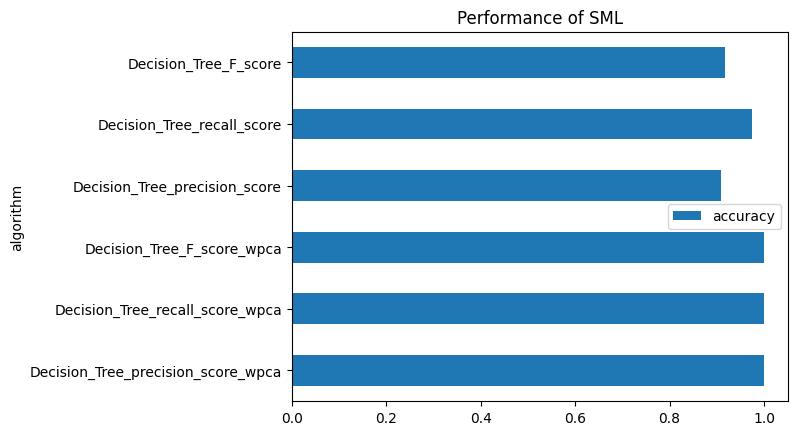

In [30]:
accuracy_results_df = pd.DataFrame(list(accuracy_results.items()),columns=['algorithm','accuracy'])
display(accuracy_results_df)
#ccuracy_results_df = accuracy_results_df.drop([0,2])
#isplay(accuracy_results_df)
accuracy_results_df.plot.barh(x='algorithm', title = 'Performance of SML');

## Calculate Probaily 

,Test_Name,1,2,3,4,5,6,7,8,9,10
0,redis_memtier_4cpu,0.434581,0.101923,0.078169,0.064043,0.062889,0.062707,0.059428,0.051018,0.042787,0.042455
1,resnet50_int8,0.332209,0.128036,0.103382,0.103160,0.081375,0.073200,0.051962,0.044895,0.041098,0.040684
2,resnet50_fp32,0.316884,0.128720,0.125993,0.104695,0.075711,0.075120,0.051699,0.042824,0.041539,0.036815
3,redis_memtier_12cpu,0.412276,0.088195,0.086749,0.082469,0.082224,0.069521,0.055978,0.049803,0.036810,0.035975
4,redis_memtier_16cpu,0.406258,0.088389,0.086461,0.086206,0.084697,0.070479,0.056930,0.047634,0.036622,0.036326
5,redis_memtier_2cpu_gated,0.447493,0.122877,0.081972,0.063522,0.056045,0.055972,0.053249,0.042730,0.040984,0.035156
6,redis_memtier_8cpu,0.420612,0.092990,0.084053,0.076195,0.075964,0.067872,0.054505,0.053294,0.038871,0.035644
7,benchdnn_bf16,0.455569,0.113878,0.095203,0.055409,0.053424,0.051453,0.048968,0.046348,0.041815,0.037934
8,resnet101_throughput_avx_fp32,0.326542,0.222015,0.115918,0.071794,0.060415,0.050047,0.046414,0.044347,0.031604,0.030904
9,resnet101_throughput_amx_fp32,0.323582,0.225371,0.114867,0.071800,0.061560,0.049941,0.045993,0.043946,0.031628,0.031312


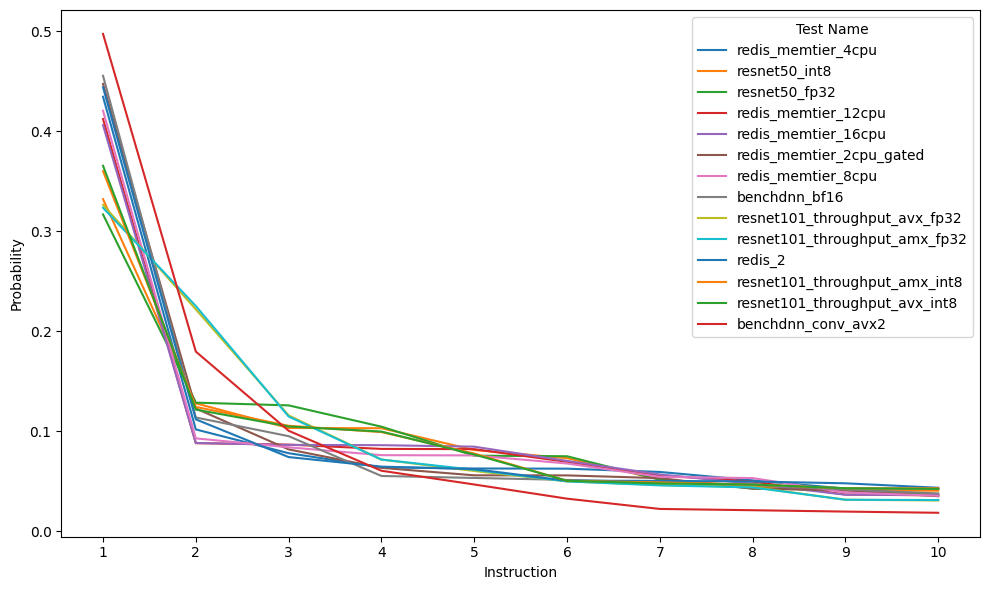

In [31]:
all_data = []

def calculate_probabilities(df):
    sorted_df = df.sort_values(by='count', ascending=False)
    top_counts = sorted_df.head(10)['count']
    total_count = top_counts.sum()
    probabilities = top_counts / total_count
    result = dict(zip(sorted_df.head(10)['mnemonic'], probabilities))
    return result

files = dir_list = os.listdir("tests/pre_silicon_runs_ml_db")
for file_name in files:
    test_name = file_name.strip("csv").strip(".")
    df = read_histogram(os.path.join("tests/pre_silicon_runs_ml_db",file_name))
    probabilities = calculate_probabilities(df)
    # Extract the top 10 instructions and their probabilities
    top_instructions = list(probabilities.keys())[:10]
    prob_values = list(probabilities.values())[:10]
        
    # Append data to the list
    data_row = {'Test_Name': test_name}
    for i, prob_value in enumerate(prob_values, start=1):
        data_row[str(i)] = prob_value
    all_data.append(data_row)

# Create DataFrame from the collected data
df = pd.DataFrame(all_data)
display(df)

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each row (test) in the DataFrame
for index, row in df.iterrows():
    # Skip the 'Test_Name' column
    values = row.iloc[1:].astype(float)  # Start from index 1 to skip the 'Test_Name' column
    plt.plot(range(1, 11), values.values, label=index)

# Add labels and legend
#plt.title('Top 10 Instructions Probabilities for Each Test')
plt.xlabel('Instruction')
plt.ylabel('Probability')
plt.xticks(range(1, 11))
plt.legend(title='Test Name', labels=df['Test_Name'].values)  # Use the 'Test_Name' column for legend labels
plt.tight_layout()
plt.show()

## Calculate entropy 

PMF = 0.9999999999999986
PMF = 1.000000000000001
PMF = 1.0000000000000002
PMF = 1.0000000000000018
PMF = 0.9999999999999999
PMF = 1.0000000000000007
PMF = 0.9999999999999992
PMF = 1.0000000000000004
PMF = 1.0000000000000009
PMF = 1.0000000000000004
PMF = 1.0000000000000013
PMF = 0.9999999999999999
PMF = 0.9999999999999998
PMF = 1.0000000000000007
                        Test_Name   Entropy
0              redis_memtier_4cpu  4.423212
1                   resnet50_int8  4.799526
2                   resnet50_fp32  4.725774
3             redis_memtier_12cpu  4.340233
4             redis_memtier_16cpu  4.314753
5        redis_memtier_2cpu_gated  4.492507
6              redis_memtier_8cpu  4.375839
7                   benchdnn_bf16  4.800080
8   resnet101_throughput_avx_fp32  4.379258
9   resnet101_throughput_amx_fp32  4.389028
10                        redis_2  4.440583
11  resnet101_throughput_amx_int8  4.801655
12  resnet101_throughput_avx_int8  4.801866
13             benchdnn_conv_avx2  

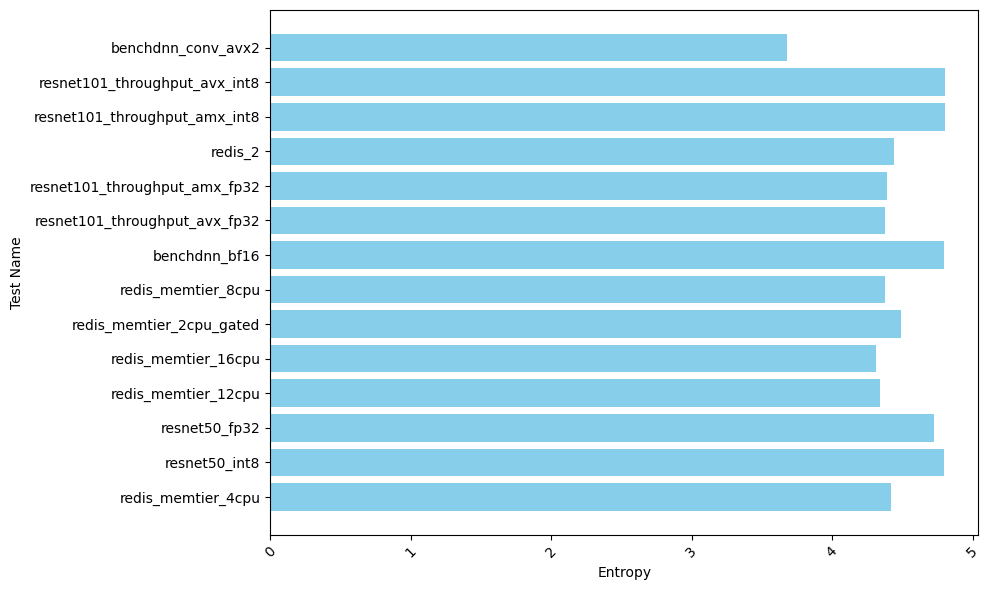

In [32]:
def calculate_probabilities(df):
    sorted_df = df.sort_values(by='count', ascending=False)
    top_counts = sorted_df['count']
    total_count = top_counts.sum()
    probabilities = top_counts / total_count
    result = dict(zip(sorted_df['mnemonic'], probabilities))
    return result

def calculate_pmf(df):
    sorted_df = df.sort_values(by='count', ascending=False)
    top_counts = sorted_df['count']
    total_count = top_counts.sum()
    probabilities = top_counts / total_count
    result = dict(zip(sorted_df['mnemonic'], probabilities))
    return result

def calculate_total_pmf(df):
    pmf_result = calculate_pmf(df)
    total_pmf = sum(pmf_result.values())
    return total_pmf

def calculate_entropy(df):
    entropy_total = 0
    # Initialize an empty list to store entropy values
    prob = calculate_probabilities(df)
    pmf = calculate_total_pmf(df)
    print(f"PMF = {pmf}")
    for instruction, prob_value in prob.items():
        if prob_value > 0.0:
            entropy = prob_value * np.log2(prob_value)
            entropy_total+=entropy
    return -(entropy_total)

# Initialize lists to store test names and entropy values
test_names = []
entropy_values = []

files = dir_list = os.listdir("tests/pre_silicon_runs_ml_db")
for file_name in files:
    test_name = file_name.strip("csv").strip(".")
    df = read_histogram(os.path.join("tests/pre_silicon_runs_ml_db",file_name))
    entropy = calculate_entropy(df)
    # Append test name and entropy value to lists
    test_names.append(test_name)
    entropy_values.append(entropy)

# Create DataFrame
df_entropy = pd.DataFrame({'Test_Name': test_names, 'Entropy': entropy_values})

print(df_entropy)
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_entropy['Test_Name'], df_entropy['Entropy'], color='skyblue')
#plt.title('Entropy for Each Test')
plt.xlabel('Entropy')
plt.ylabel('Test Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Workload with minimum simulation time: redis_memtier_8cpu, Time: 9, Entropy: 4.375838858176186 
Cluster size = 1 Sim time = 9 Mean Entropy = 4.375838858176186
Workload with minimum simulation time: resnet101_throughput_amx_fp32, Time: 32, Entropy: 4.389027759452521 
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9, Entropy: 4.375838858176186 
Cluster size = 2 Sim time = 41 Mean Entropy = 4.3824333088143534
Workload with minimum simulation time: resnet101_throughput_amx_fp32, Time: 32, Entropy: 4.389027759452521 
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9, Entropy: 4.375838858176186 
Workload with minimum simulation time: resnet101_throughput_amx_int8, Time: 61, Entropy: 4.801655171775304 
Cluster size = 3 Sim time = 102 Mean Entropy = 4.522173929801337
Workload with minimum simulation time: redis_memtier_8cpu, Time: 9, Entropy: 4.375838858176186 
Workload with minimum simulation time: resnet101_throughput_amx_int8, Time: 61, Entropy: 4.80165517

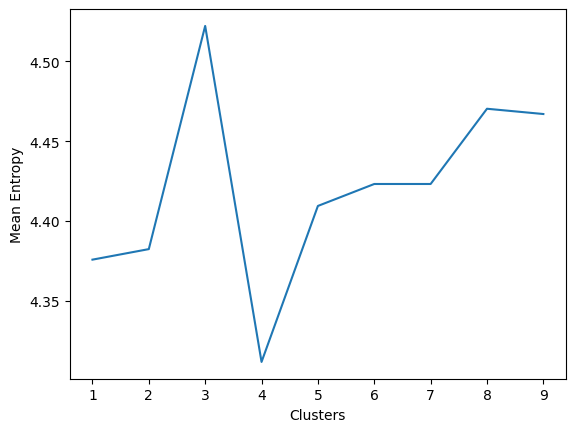

In [33]:
def find_min_simulation_time(df, workloads):
    # Filter the DataFrame based on the provided set of workloads
    filtered_df = df[df['test_name'].isin(workloads)]
    
    # Find the row with the minimum simulation time
    min_row = filtered_df.loc[filtered_df['simulation_time'].idxmin()]
    
    # Extract the workload name and minimum simulation time
    min_workload = min_row['test_name']
    min_time = min_row['simulation_time']
    
    return min_workload, min_time

total_clusters_time_v = []
mean_entropy_list = []
for x in range(1,10):
    df_result_,kmeans,SSE = kmean_cluster(pca_df,x)
    workloads_per_cluster = {}
    total_clusters_time = 0
    total_entropy = 0
    for cluster, group in df_result_.groupby('PRED'):
        workloads = set(group['test_name'].unique())
        min_workload, min_time = find_min_simulation_time(pca_df, workloads)
        entropy = df_entropy[df_entropy['Test_Name'] == min_workload]['Entropy'].iloc[0]
        total_entropy += entropy
        print(f"Workload with minimum simulation time: {min_workload}, Time: {min_time}, Entropy: {entropy} ")
        mean_entropy = total_entropy/x
        total_clusters_time += min_time
    mean_entropy_list.append(mean_entropy)
    print(f"Cluster size = {x} Sim time = {total_clusters_time} Mean Entropy = {mean_entropy}")
    total_clusters_time_v.append(total_clusters_time)

    
# Plot the list
# Define x-values starting from 1
x_values = range(1, len(mean_entropy_list) + 1)
# Plot the list with custom x-values
plt.plot(x_values, mean_entropy_list)
plt.xlabel('Clusters')
plt.ylabel('Mean Entropy')
#plt.title('Mean Entropy over multiple clusters of best sim time vs SSE')
plt.show()


# Back up 